# 0.Import Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import networkx as nx
import nxviz as nv
import matplotlib.pyplot as plt
from collections import defaultdict
plt.style.use('seaborn-v0_8-darkgrid')

d:\Çalışmalar\Projeler\GitHubRepos\DataCampCourses\Intermediate_Network_Analysis_in_Python\environment\lib\site-packages\nxviz\__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.4 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.4, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


# 1.Dataset Info Function

* This function will give info about the dataset.
* I will use it in the entire notebook

In [2]:
def create_analysis_dataframe(dataset):
    list=[]
    for column in dataset.columns:
        data_type = dataset.dtypes[column]
        unique_number = dataset[column].unique().size
        null_ratio = dataset[column].isnull().sum()/dataset.shape[0]
        most_frequent_value = dataset[column].value_counts().idxmax()
        least_frequent_value = dataset[column].value_counts().idxmin()
        min_value = dataset[column].min(skipna=True, numeric_only=False)
        max_value = dataset[column].max(skipna=True, numeric_only=False)
        list.append([column,data_type,unique_number,null_ratio,most_frequent_value,least_frequent_value,min_value,max_value])
    dataset_info=pd.DataFrame(list,columns=['Name',
                                            'Data_Type',
                                            'Unique_Size',
                                            'Null_Ratio',
                                            'Most_Frequent_Value',
                                            'Least_Frequent_Value',
                                           'Min_Value',
                                           'Max_Value']).sort_values(by=['Unique_Size','Name'],
                                                                                 ascending=True,
                                                                                ignore_index=True)
    return dataset_info

# 1.Load Dataset

In [4]:
movies = pd.read_csv('Data\\movies.csv')
ratings = pd.read_csv('Data\\ratings.csv')

In [4]:
create_analysis_dataframe(movies)

,Name,Data_Type,Unique_Size,Null_Ratio,Most_Frequent_Value,Least_Frequent_Value,Min_Value,Max_Value
0,genres,object,1639,0.0,Drama,Action|Children|Fantasy|Sci-Fi,(no genres listed),Western
1,title,object,62325,0.0,The Void (2016),Botany Bay (1953),"""BLOW THE NIGHT!"" Let's Spend the Night Togeth...",줄탁동시 (2012)
2,movieId,int64,62423,0.0,1,1,1,209171


In [5]:
create_analysis_dataframe(ratings)

,Name,Data_Type,Unique_Size,Null_Ratio,Most_Frequent_Value,Least_Frequent_Value,Min_Value,Max_Value
0,rating,float64,10,0.0,4.0,5.000000e-01,0.5,5.000000e+00
1,movieId,int64,59047,0.0,356.0,1.533180e+05,1.0,2.091710e+05
2,userId,int64,162541,0.0,72315.0,1.597620e+05,1.0,1.625410e+05
3,timestamp,int64,20115267,0.0,825638400.0,1.567293e+09,789652009.0,1.574328e+09


In [6]:
ratings.shape

(25000095, 4)

In [7]:
del movies

**For graph theory, I only need ratings dataframe, this is why I am deleting movies dataframe.**

**Looking at the results above, the dataframe has no null or infinite values, so no preprocessing is needed.**


# 2.Merging and Structuring Movie Ratings Data
* **The dataset is too big for this project, I don't need 25 million rows so I wanna drop some of them.**
* **I will chose the with least value counts movies and users and I will remove them.**

In [8]:
create_analysis_dataframe(ratings)

,Name,Data_Type,Unique_Size,Null_Ratio,Most_Frequent_Value,Least_Frequent_Value,Min_Value,Max_Value
0,rating,float64,10,0.0,4.0,5.000000e-01,0.5,5.000000e+00
1,movieId,int64,59047,0.0,356.0,1.533180e+05,1.0,2.091710e+05
2,userId,int64,162541,0.0,72315.0,1.597620e+05,1.0,1.625410e+05
3,timestamp,int64,20115267,0.0,825638400.0,1.567293e+09,789652009.0,1.574328e+09


* **The decreased dataset has almost 2.5 million rows.**

In [9]:
final_data = ratings.sample(frac=0.03, weights='rating', random_state=1)

movies_exist_1_time = final_data['movieId'].value_counts().sort_values()[:19000].index
final_data = final_data[~final_data['movieId'].isin(movies_exist_1_time)]

# converting timestamp to readible date column 
final_data['date'] = pd.to_datetime(final_data['timestamp'],unit='s')
final_data = final_data.drop('timestamp', axis=1)

# seperating date column 
final_data['year'] = final_data['date'].dt.year
final_data['month'] = final_data['date'].dt.month

# I'm adding a small character to each node type to distinguish between them. 
# This is because both the userId and movieId columns have overlapping numbers (e.g., a user and a movie can both have an ID of 10).
final_data['movieId'] = 'm' + final_data['movieId'].astype('str')
final_data['userId'] = 'u' + final_data['userId'].astype('str')

del ratings, movies_exist_1_time
# first look to processed data
final_data.head()

,userId,movieId,rating,date,year,month
10435637,u67708,m2278,4.0,2000-10-27 04:43:46,2000,10
18013724,u116679,m2081,4.0,1999-12-31 17:29:54,1999,12
2847,u13,m81834,3.5,2011-02-17 02:07:49,2011,2
7560292,u49045,m2997,2.0,2005-05-05 19:45:34,2005,5
2305756,u15339,m6934,1.5,2006-05-17 20:19:46,2006,5


In [10]:
create_analysis_dataframe(final_data)

,Name,Data_Type,Unique_Size,Null_Ratio,Most_Frequent_Value,Least_Frequent_Value,Min_Value,Max_Value
0,rating,float64,10,0.0,4.0,0.5,0.5,5.0
1,month,int32,12,0.0,11,9,1,12
2,year,int32,24,0.0,1996,1998,1996,2019
3,movieId,object,1074,0.0,m318,m562,m1,m99114
4,userId,object,125338,0.0,u92046,u137677,u1,u99999
5,date,datetime64[ns],478497,0.0,1996-03-01 00:00:00,2005-07-18 03:44:46,1996-01-29 00:00:00,2019-11-21 08:55:21


# 3.Creating Graph

In [11]:
G = nx.Graph()

G.add_nodes_from(final_data['userId'].unique(), bipartite='users')
G.add_nodes_from(final_data['movieId'].unique(), bipartite='movies')

for index, row in final_data.iterrows():
    G.add_edge(row['userId'], row['movieId'],weight=row['rating'],month=row['month'],year=row["year"])

del final_data
print(f"------------------------- GRAPH VALUES -------------------------------------")
print("Number of nodes :",len(G.nodes()))
print("Number of edges :",len(G.edges()))

------------------------- GRAPH VALUES -------------------------------------
Number of nodes : 126412
Number of edges : 484740


# 4.Bipartite Degree Centrality

In [12]:
user_list = [n for n in G.nodes() if G.nodes[n]['bipartite']=='users']
movie_list = [n for n in G.nodes() if G.nodes[n]['bipartite']=='movies']

In [13]:
bipartite_degree_centrality = sorted(nx.bipartite.degree_centrality(G, nodes=movie_list).items(), key=lambda x:x[1], reverse=True)

### Top 10 users with the highest degree centrality

In [14]:
i = 0
for x in bipartite_degree_centrality:
    if i>= 10:
        break
    if x[0] in user_list and i<10:
        print(x)
        i += 1

('u92046', 0.03910614525139665)
('u65365', 0.038175046554934824)
('u56282', 0.03631284916201117)
('u44147', 0.03631284916201117)
('u127311', 0.035381750465549346)
('u60655', 0.035381750465549346)
('u29021', 0.0335195530726257)
('u51238', 0.0335195530726257)
('u46264', 0.0335195530726257)
('u110971', 0.032588454376163874)


### Top 10 movies with the highest degree centrality

In [15]:
i = 0
for x in bipartite_degree_centrality:
    if i>= 10:
        break
    if x[0] in movie_list and i<10:
        print(x)
        i += 1

('m318', 0.02483684118144537)
('m296', 0.022858191450318338)
('m356', 0.022211938917167977)
('m593', 0.020664124208141187)
('m2571', 0.020464663549761446)
('m260', 0.01896471939874579)
('m527', 0.017951459254176707)
('m2959', 0.016842457993585344)
('m50', 0.01581324099634588)
('m1198', 0.015773348864669932)


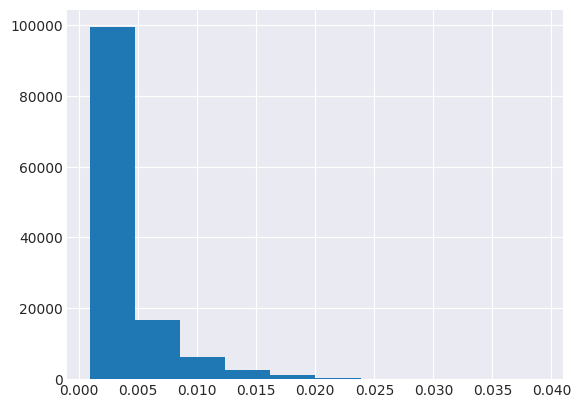

In [16]:
# Compute the degree centrality of the Twitter network: deg_cent
deg_cent = nx.bipartite.degree_centrality(G, nodes=movie_list)

# Plot a histogram of the degree centrality distribution of the graph.
plt.figure()
plt.hist(list(deg_cent.values()))
plt.show()

In [17]:
del deg_cent, bipartite_degree_centrality

# 5.Getting a small subgraph using an array

In [18]:
nodes_of_interest = ['u92046','u65365','u56282','u44147','u127311','u60655','u46264','u29021','u51238']

# Define get_nodes_and_nbrs()
def get_nodes_and_nbrs(G, nodes_of_interest):
    """
    Returns a subgraph of the graph `G` with only the `nodes_of_interest` and their neighbors.
    """
    nodes_to_draw = []

    # Iterate over the nodes of interest
    for n in nodes_of_interest:

        # Append the nodes of interest to nodes_to_draw
        nodes_to_draw.append(n)

        # Iterate over all the neighbors of node n
        for nbr in G.neighbors(n):

            # Append the neighbors of n to nodes_to_draw
            nodes_to_draw.append(nbr)

    return G.subgraph(nodes_to_draw)


T_draw = get_nodes_and_nbrs(G,nodes_of_interest)
del nodes_of_interest

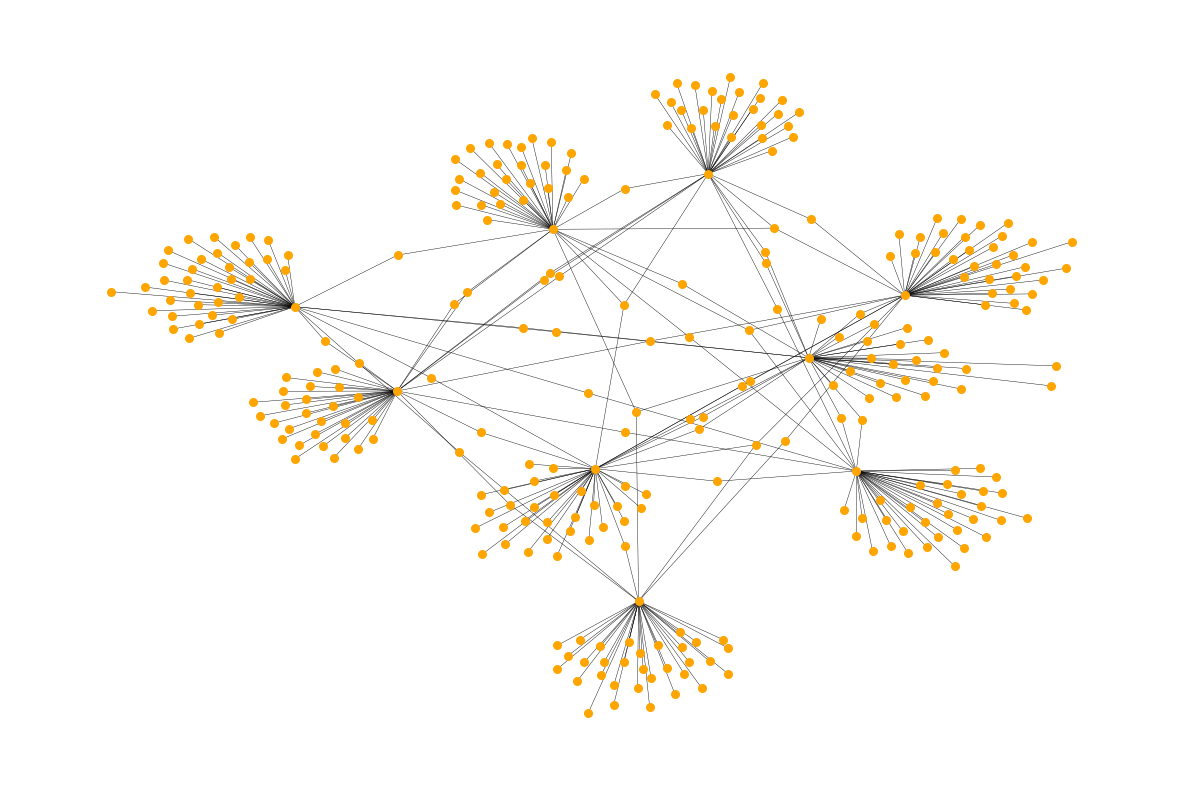

In [19]:
# Draw the subgraph to the screen
# Extract the subgraph with the nodes of interest: T_draw
fig, ax = plt.subplots(figsize=(15,10))
options = {
    'node_color': 'orange',
    'width': 0.3,
    'node_size' : 30,
    'with_labels': False
}
nx.draw(T_draw, **options)
fig.show()

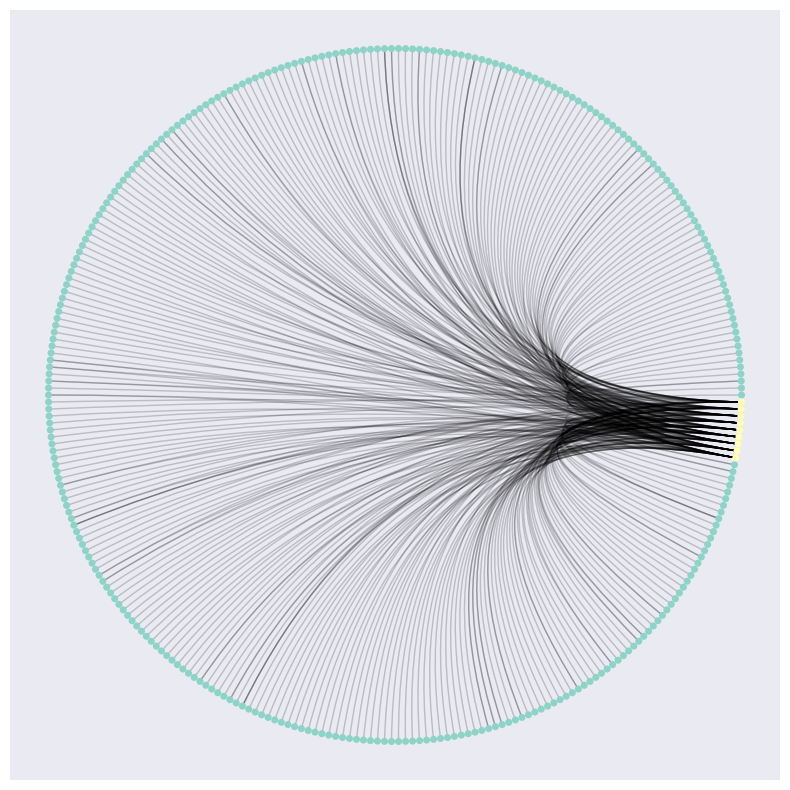

In [20]:
fig, ax = plt.subplots(figsize=(15,10))
ax = nv.circos(
    T_draw,
    node_color_by="bipartite",
    group_by='bipartite',
    # edge_alpha_by="weight",
)
fig.show()

# 6.Checking if a path exists between two nodes

In [21]:
def path_exists(G, node1, node2):
    """
    This function checks whether a path exists between two nodes (node1, node2) in graph G.
    """
    visited_nodes = set()
    queue = [node1]

    for node in queue:
        neighbors = list(G.neighbors(node))
        if node2 in neighbors:
            print('Path exists between nodes {0} and {1}'.format(node1, node2))
            return True
            break

        else:
            visited_nodes.add(node)
            queue.extend([n for n in neighbors if n not in visited_nodes])

        # Check to see if the final element of the queue has been reached
        if node == queue[-1]:
            print('Path does not exist between nodes {0} and {1}'.format(node1, node2))

            # Place the appropriate return statement
            return False

In [22]:
path_exists(G, 'u15339', 'u67708')

Path exists between nodes u15339 and u67708


True

In [23]:
path_exists(G, 'u100', 'u99999')

Path exists between nodes u100 and u99999


True

# 7.Degree Centrality 

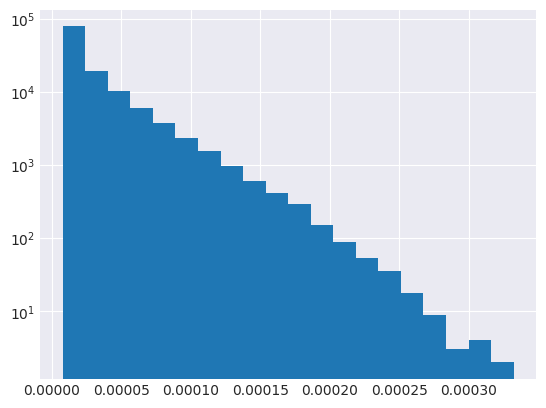

In [24]:
# Compute the degree centralities: dcs
dcs = nx.degree_centrality(G)

# Get the degree centralities for user_nodes: user_dcs
user_dcs = [dcs[n] for n in user_list]

# Plot the degree distribution of users_dcs
plt.yscale('log')
plt.hist(user_dcs, bins=20)
plt.show()

In [25]:
del dcs, user_dcs

# 8.Shared Partition Nodes

In [26]:
def shared_partition_nodes(G, node1, node2):
    # Check that the nodes belong to the same partition
    assert G.nodes[node1]['bipartite'] == G.nodes[node2]['bipartite']

    # Get neighbors of node 1: nbrs1
    nbrs1 = G.neighbors(node1)
    # Get neighbors of node 2: nbrs2
    nbrs2 = G.neighbors(node2)

    # Compute the overlap using set intersections
    overlap = set(nbrs1).intersection(nbrs2)
    return overlap

In [27]:
print("Shared node between u44147 and u10429 : ",len(shared_partition_nodes(G, 'u44147', 'u10429')))

Shared node between u44147 and u10429 :  0


In [28]:
print("Shared node between u92046 and u60655 : ",len(shared_partition_nodes(G, 'u92046', 'u60655')))

Shared node between u92046 and u60655 :  1


# 9.Calculation User Similarity

In [29]:
def user_similarity(G, user1, user2, proj_nodes):
    # Check that the nodes belong to the 'users' partition
    assert G.nodes[user1]['bipartite'] == 'users'
    assert G.nodes[user2]['bipartite'] == 'users'

    # Get the set of nodes shared between the two users
    shared_nodes = shared_partition_nodes(G,user1,user2)

    # Return the fraction of nodes in the projects partition
    return len(shared_nodes) / len(proj_nodes)

In [30]:
print("Shared node between u44147 and u10429 : ",user_similarity(G, 'u44147', 'u10429', user_list))

Shared node between u44147 and u10429 :  0.0


In [31]:
print("Shared node between u92046 and u60655 : ",user_similarity(G, 'u92046', 'u60655', user_list))

Shared node between u92046 and u60655 :  7.978426335189647e-06


In [32]:
print("Shared node between u504 and u42804 : ",user_similarity(G, 'u504', 'u42804', user_list))

Shared node between u504 and u42804 :  1.5956852670379295e-05


# 10.Find the most similar users

In [33]:
def most_similar_users(G, user, user_nodes, proj_nodes):
    # Data checks
    assert G.nodes[user]['bipartite'] == 'users'

    # Get other nodes from user partition
    user_nodes = set(user_nodes)
    user_nodes.remove(user)
 
    # Create the dictionary: similarities
    similarities = defaultdict(list)
    for n in user_nodes:
        similarity = user_similarity(G, user, n, proj_nodes)
        similarities[similarity].append(n)

    # Compute maximum similarity score: max_similarity
    max_similarity = max(similarities.keys())

    # Return list of users that share maximal similarity
    return similarities[max_similarity]

In [34]:
print("Most similar users to u504 : ",most_similar_users(G, 'u504', user_list, movie_list))

Most similar users to u504 :  ['u162067', 'u50830', 'u70941', 'u131331', 'u42804', 'u5674', 'u148422']


In [35]:
print("Most similar users to u92046 : ",most_similar_users(G, 'u92046', user_list, movie_list))

Most similar users to u92046 :  ['u126970', 'u74644', 'u96976']


# 11.Recommending Movies

In [36]:
def recommend_movies(G, from_user, to_user):
    # Get the set of movies that from_user has contributed to
    from_repos = set(G.neighbors(from_user))
    # Get the set of movies that to_user has contributed to
    to_repos = set(G.neighbors(to_user))

    # Identify movies that the from_user is connected to that the to_user is not connected to
    return from_repos.difference(to_repos)

In [37]:
# Print the movies to be recommended
print("Recommending from 'u504' to 'u74644' :",recommend_movies(G, 'u504', 'u74644'))

Recommending from 'u504' to 'u74644' : {'m88744', 'm1682'}


# 12.Computing Projection
**First I wanted to compute projection of G but it took too long to compute so I compute T_draw's projection**

In [38]:
# Compute the users and movies projections: usersG, moviesG
user_t_draw = [n for n in T_draw.nodes() if T_draw.nodes[n]['bipartite'] == 'users']
movies_t_draw = [n for n, d in T_draw.nodes(data=True) if d['bipartite'] == 'movies']

userG = nx.bipartite.projected_graph(T_draw, user_t_draw)
moviesG = nx.bipartite.projected_graph(T_draw, movies_t_draw)

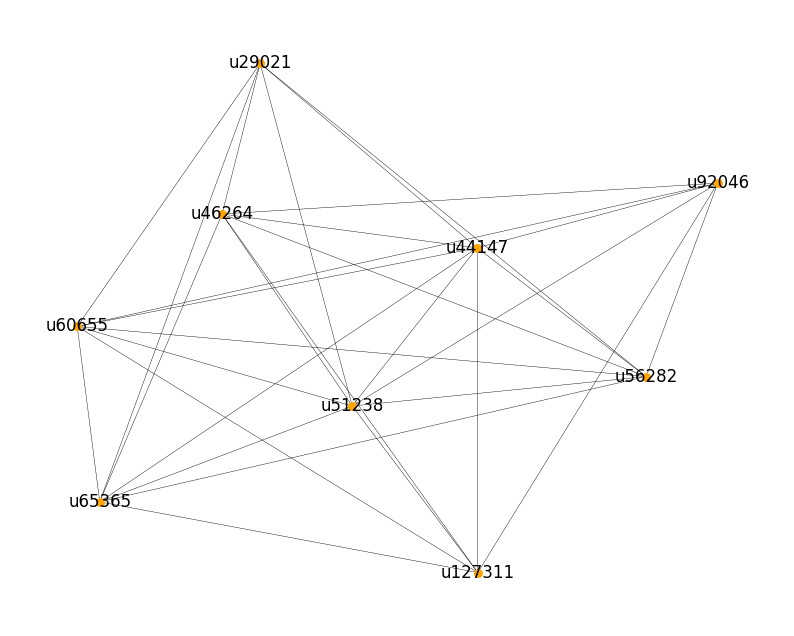

In [39]:
# Draw the subgraph to the screen
# Extract the subgraph with the nodes of interest: T_draw
fig, ax = plt.subplots(figsize=(10,8))
options = {
    'node_color': 'orange',
    'width': 0.3,
    'node_size' : 30,
    'with_labels': True
}
nx.draw(userG, **options)
fig.show()

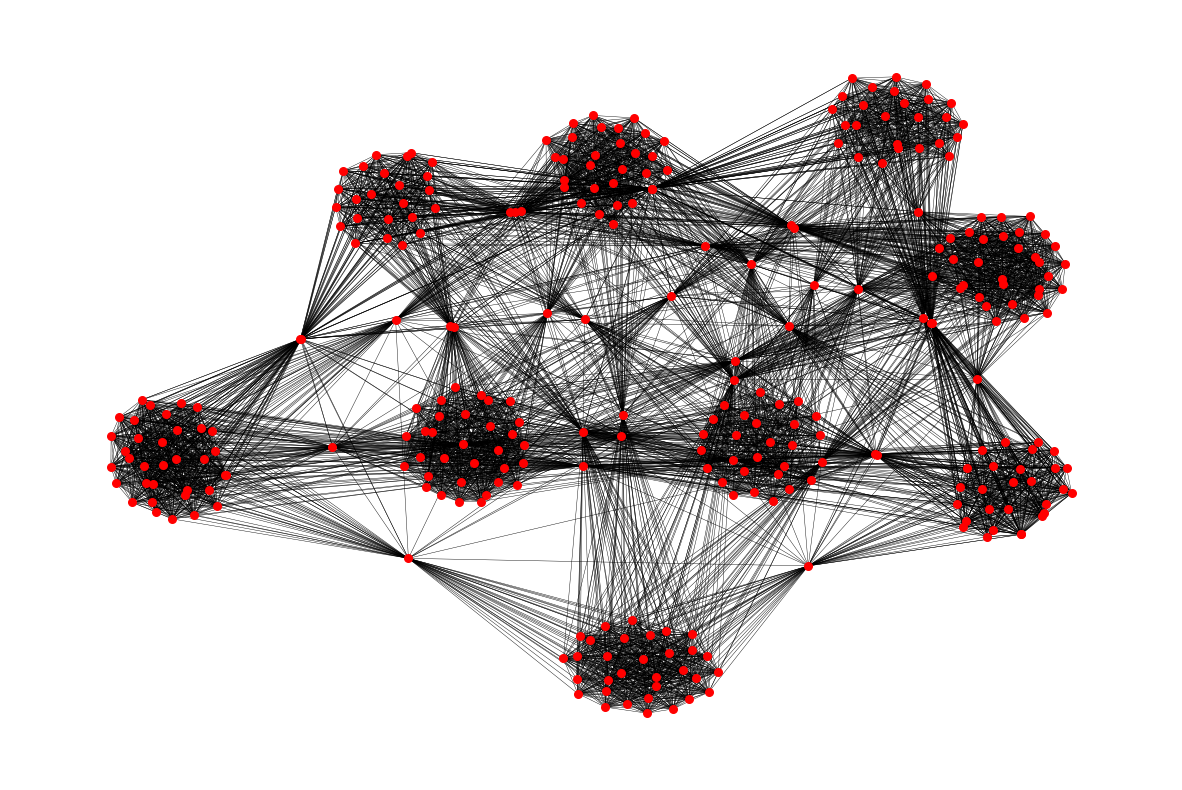

In [40]:
# Draw the subgraph to the screen
# Extract the subgraph with the nodes of interest: T_draw
fig, ax = plt.subplots(figsize=(15,10))
options = {
    'node_color': 'red',
    'width': 0.3,
    'node_size' : 30,
    'with_labels': False
}
nx.draw(moviesG, **options)
fig.show()

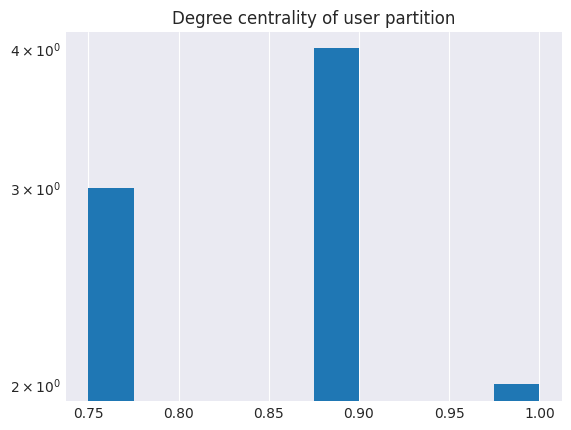

In [41]:
# Plot the degree centrality distribution of the userG graph
plt.figure()
user_dc = nx.degree_centrality(userG)
plt.hist(user_dc.values())
plt.yscale('log')
plt.title('Degree centrality of user partition')
plt.show()

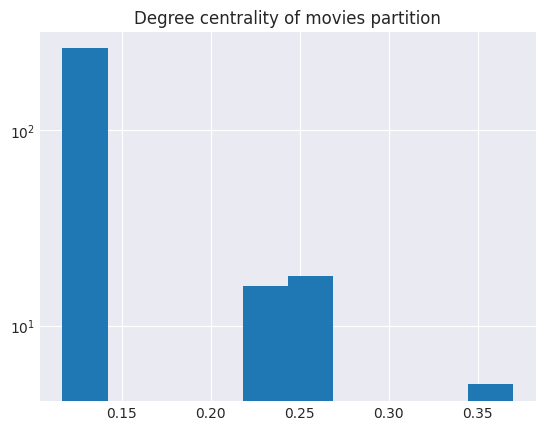

In [42]:
# Plot the degree centrality distribution of the moviesG graph
plt.figure()
movies_dc = nx.degree_centrality(moviesG)
plt.hist(movies_dc.values())
plt.yscale('log')
plt.title('Degree centrality of movies partition')
plt.show()

In [43]:
del user_t_draw, movies_t_draw, moviesG, userG, user_dc, movies_dc

# 13.Compute the biadjacency matrix

In [44]:
bi_matrix = nx.bipartite.biadjacency_matrix(G, 
                                            row_order=user_list, 
                                            column_order=movie_list)

# Compute the user-user projection: user_matrix
user_matrix = bi_matrix @ bi_matrix.T

# Find out the names of people who were members of the most number of clubs
diag = user_matrix.diagonal() 
indices = np.where(diag == diag.max())[0]  
print('Number of clubs: {0}'.format(diag.max()))
print('People with the most number of ratings:')
for i in indices:
    print('- {0}'.format(user_list[i]))
    
del bi_matrix, user_matrix, diag, indices

Number of clubs: 791.25
People with the most number of ratings:
- u92046


# 14.Evolving Graph

In [110]:
from functools import reduce

def unique(list1):
    # Print directly by using * symbol
    ans = reduce(lambda re, x: re+[x] if x not in re else re, list1, [])
    return ans
        
months = []

for u, v, d in G.edges(data=True):       
    months.append(d['month'])

months_unique = unique(months)

In [111]:
# Initialize an empty list: Gs
Gs = [] 
for month in months_unique:
    # Instantiate a new undirected graph: G
    T = nx.Graph()
    
    # Add in all nodes that have ever shown up to the graph
    T.add_nodes_from(G.nodes(data=True))
    
    dictionary = {}
    for u,v,d in G.edges(data=True):
        if d['month'] == month:
            dictionary[u] = v
    
    # Add edges from filtered DataFrame
    for key, value in dictionary.items():
        T.add_edge(key,value)
    
    # Append G to the list of graphs
    Gs.append(T)

In [112]:
print("Total number of graphs group by month: ",len(Gs))

Total number of graphs group by month:  12


In [113]:
for x in range(len(Gs)):
    print(f"------------------------- GRAPH {x} VALUES -------------------------------------")
    print("Number of nodes :",len(Gs[x].nodes()))
    print("Number of edges :",len(Gs[x].edges()))

------------------------- GRAPH 0 VALUES -------------------------------------
Number of nodes : 126412
Number of edges : 15126
------------------------- GRAPH 1 VALUES -------------------------------------
Number of nodes : 126412
Number of edges : 16634
------------------------- GRAPH 2 VALUES -------------------------------------
Number of nodes : 126412
Number of edges : 14749
------------------------- GRAPH 3 VALUES -------------------------------------
Number of nodes : 126412
Number of edges : 12564
------------------------- GRAPH 4 VALUES -------------------------------------
Number of nodes : 126412
Number of edges : 14046
------------------------- GRAPH 5 VALUES -------------------------------------
Number of nodes : 126412
Number of edges : 13064
------------------------- GRAPH 6 VALUES -------------------------------------
Number of nodes : 126412
Number of edges : 14065
------------------------- GRAPH 7 VALUES -------------------------------------
Number of nodes : 126412


In [114]:
del  months, months_unique

# 15.Graph Difference Over Time

In [83]:
# Instantiate a list of graphs that show edges added: added
added = []
# Instantiate a list of graphs that show edges removed: removed
removed = []
# Here's the fractional change over time
fractional_changes = []
window = 1

for i in range(len(Gs) - window):
    g1 = Gs[i]
    g2 = Gs[i + window]
        
    # Compute graph difference here
    added.append(nx.difference(g2, g1))   
    removed.append(nx.difference(g1, g2))
    
    # Compute change in graph size over time
    fractional_changes.append((len(g2.edges()) - len(g1.edges())) / len(g1.edges()))
    
# Print the fractional change
print(fractional_changes)

[0.09969588787518181, -0.11332211133822291, -0.14814563699233846, 0.11795606494746896, -0.06991314253168161, 0.07662278015921617, 0.03021685033771774, 0.04009661835748792, -0.06582177692256652, -0.003693444136657433, -0.11121408711770157]


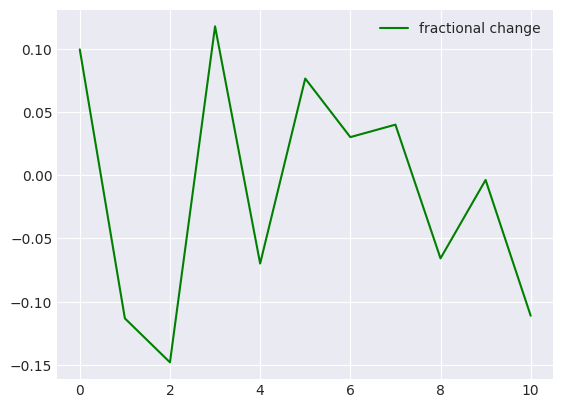

In [107]:
fig, ax = plt.subplots()

# Plot the fractional changes over time
ax.plot(fractional_changes, label='fractional change', color='green')
ax.legend()

plt.show()

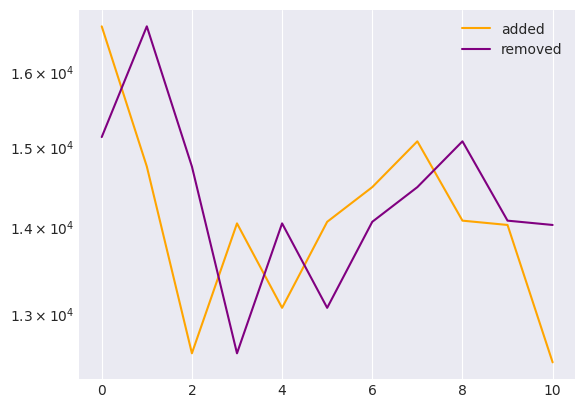

In [103]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

# Plot the number of edges added over time
edges_added = [len(g.edges()) for g in added]
plot1 = ax1.plot(edges_added, label='added', color='orange')

# Plot the number of edges removed over time
edges_removed = [len(g.edges()) for g in removed]
plot2 = ax1.plot(edges_removed, label='removed', color='purple')

# Set yscale to logarithmic scale
ax1.set_yscale('log')  
ax1.legend()

plt.show()

# 16.Number of edges over time 

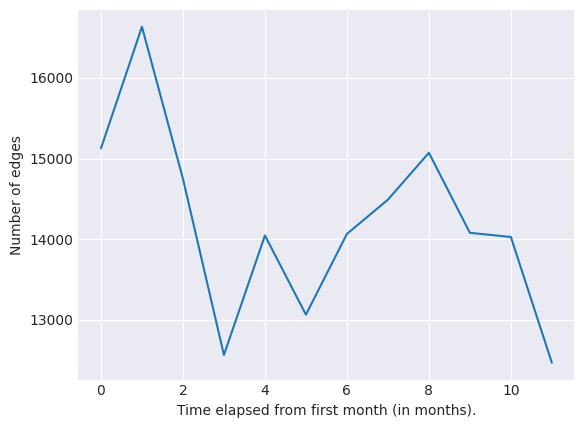

In [118]:
# Create a list of the number of edges per month
edge_sizes = [len(g.edges()) for g in Gs]

# Plot edge sizes over time
plt.plot(edge_sizes)
plt.xlabel('Time elapsed from first month (in months).') 
plt.ylabel('Number of edges')    

plt.show() 

# 17.Degree Centrality over time

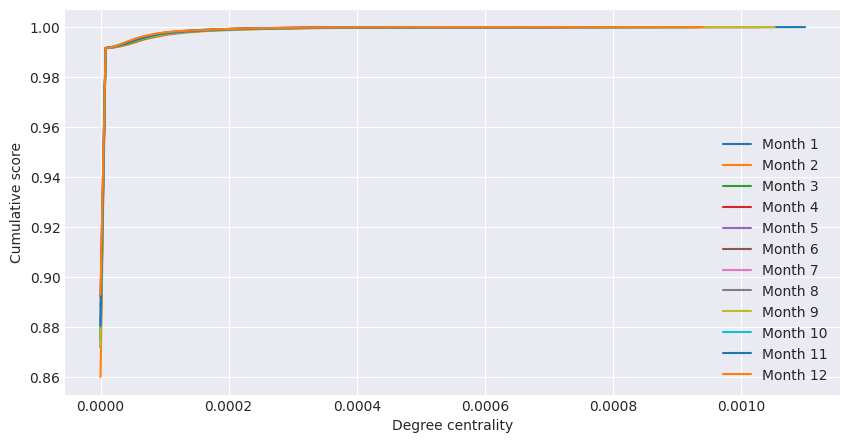

In [123]:
from scipy import stats
# Create a list of degree centrality scores month-by-month
cents = []
for G in Gs:
    cent = nx.degree_centrality(G)
    cents.append(cent)

fig, ax = plt.subplots(figsize=(10,5))
for i in range(len(cents)):
    res = stats.ecdf(list(cents[i].values()))
    plt.plot(res.cdf.quantiles, res.cdf.probabilities, label='Month {0}'.format(i+1)) 

plt.legend()  
plt.xlabel('Degree centrality')
plt.ylabel('Cumulative score')
plt.show()

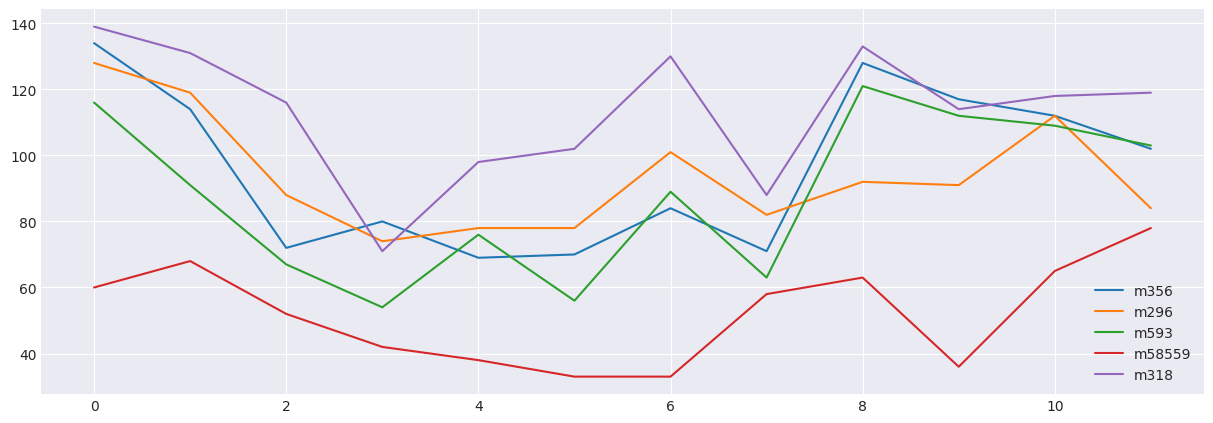

In [127]:
# Get the top 5 unique degree centrality scores: top_dcs
top_dcs = sorted(set(nx.degree_centrality(G).values()), reverse=True)[0:5]

# Create list of nodes that have the top 5 highest overall degree centralities
top_connected = []
for n, dc in nx.degree_centrality(G).items():
    if dc in top_dcs:
        top_connected.append(n)

# Create a defaultdict in which the keys are nodes and the values are a list of connectivity scores over time
connectivity = defaultdict(list)
for n in top_connected:
    for g in Gs:
        connectivity[n].append(len(list(g.neighbors(n))))

# Plot the connectivity for each node
fig, ax = plt.subplots(figsize=(15,5))
for n, conn in connectivity.items(): 
    plt.plot(conn, label=n) 
plt.legend()  
plt.show()